In [5]:
from matchviz import load_points, ome_ngff_to_coords, plot_points
import matplotlib.pyplot as plt
from matplotlib import colors
from xarray_ome_ngff import read_multiscale_group
import zarr
import polars as pl
import numpy as np

url = "s3://aind-open-data/exaSPIM_708373_2024-04-02_19-49-38_alignment_2024-05-07_18-15-25/interestpoints.n5/tpId_0_viewSetupId_0/beads/"
image_url = 's3://aind-open-data/exaSPIM_708373_2024-04-02_19-49-38/SPIM.ome.zarr/tile_x_0000_y_0000_z_0000_ch_488.zarr'

images_xarray = read_multiscale_group(
        zarr.open_group(image_url, mode='r'),
        array_wrapper={'name': 'dask_array', 'config': {'chunks': 'auto'}})
img = images_xarray['6'].drop_vars(('t','c')).squeeze()


In [7]:
coords = ome_ngff_to_coords(image_url)
points_df, match_df = load_points(url, coords=coords)
loc_xyz = np.array(points_df['loc_xyz'].to_list())

In [8]:
coords

{'t': {'scale': 1.0, 'translation': 0},
 'c': {'scale': 1.0, 'translation': 0},
 'z': {'scale': 1.0, 'translation': -28672.0},
 'y': {'scale': 0.7479999743009398, 'translation': -17509.18359375},
 'x': {'scale': 0.7480000148631624, 'translation': -5307.808105469}}

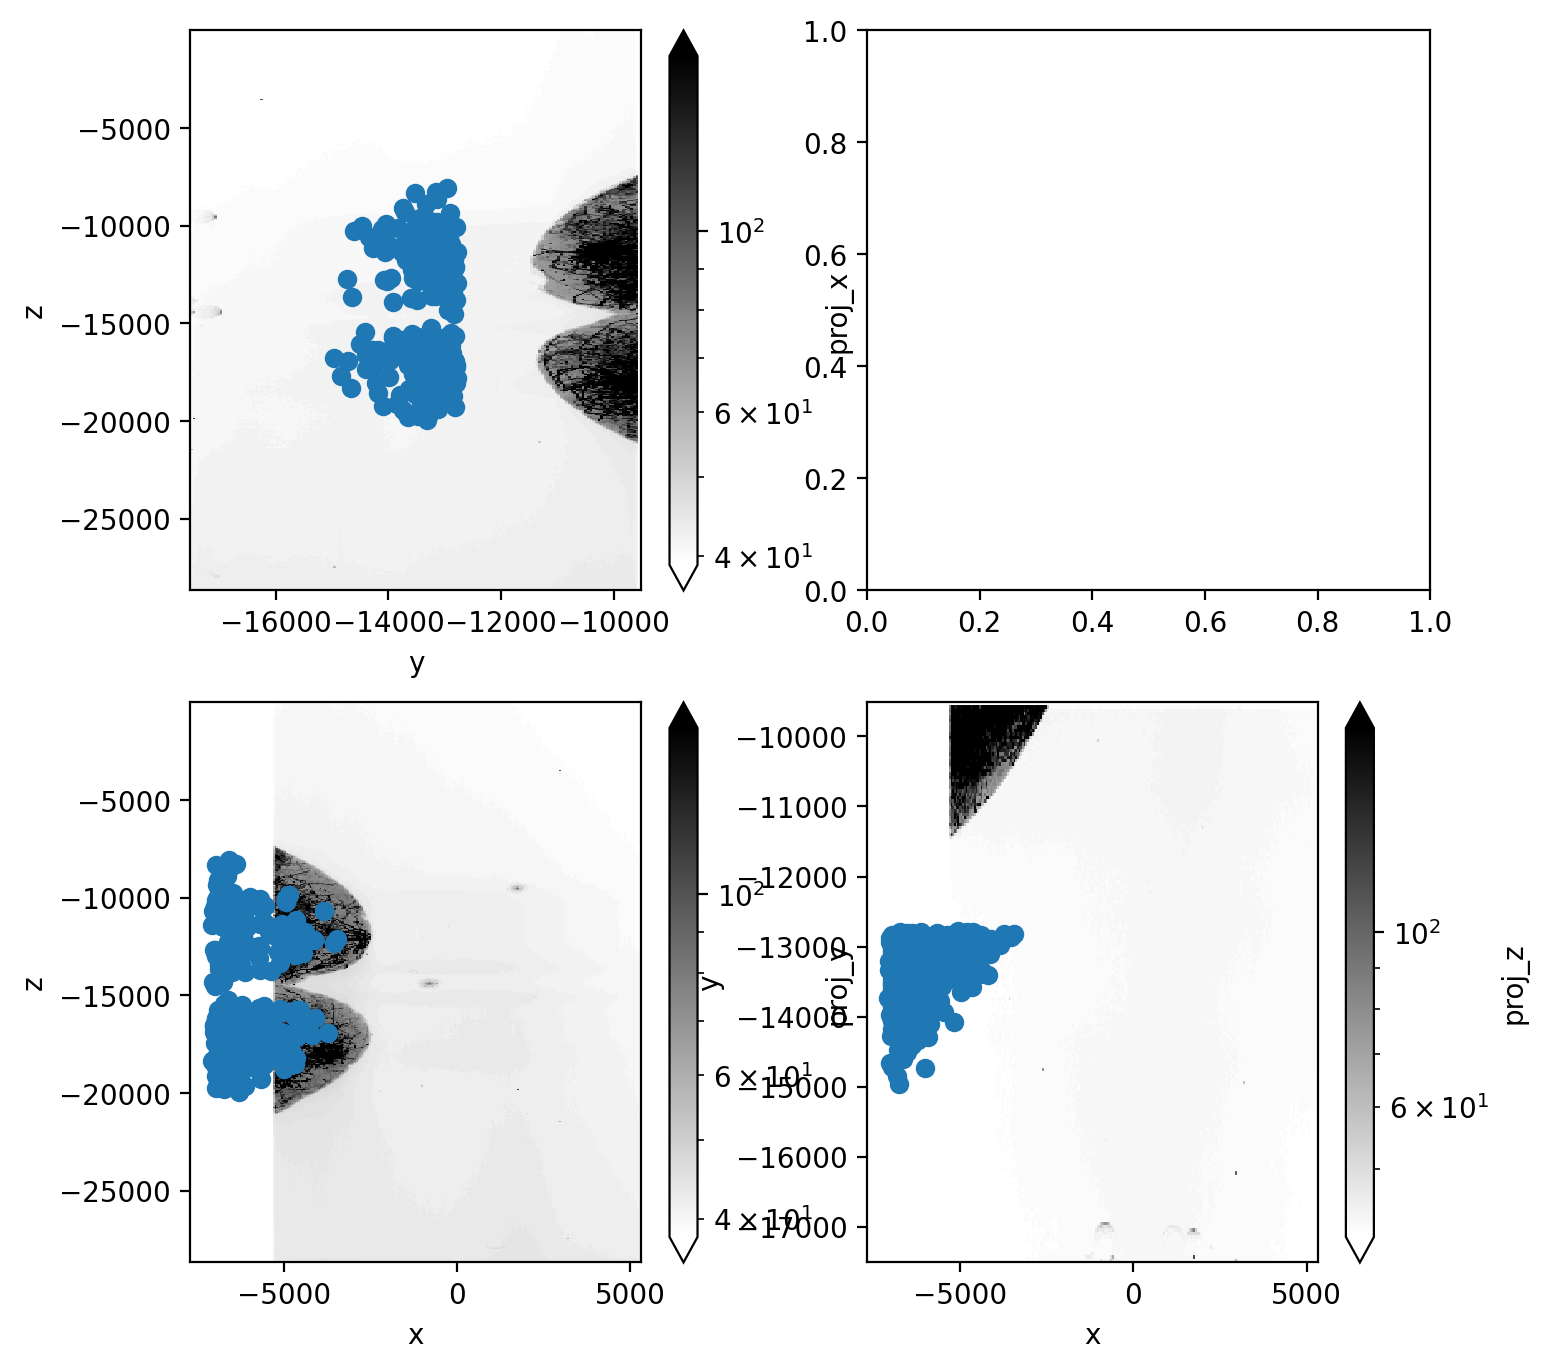

In [9]:
def plot_points(points_df: pl.DataFrame, image_group_path: str):
    
    fig, axs = plt.subplots(ncols=2, nrows=2, dpi=200, figsize=(8,8))
    ds = 100

    dims = ('x','y','z')
    yoffset = 3000

    pairs = ('z', 'y'), None, ('z', 'x'), ('x', 'y')

    for idx, pair in enumerate(pairs):
        if pair is not None:
            plot_x, plot_y = sorted(pair)
            axis = axs.ravel()[idx]
            proj_dim = tuple(set(dims) - set(pair))[0]
            proj = img.max((proj_dim)).compute()
            proj.name = f'proj_{proj_dim}'
            proj.plot.imshow(
                x=plot_x, 
                y=plot_y,
                ax=axis, 
                robust=True, 
                norm=colors.LogNorm(), 
                cmap='gray_r')

            axis.scatter(
                loc_xyz[::ds, dims.index(plot_x)], 
                loc_xyz[::ds, dims.index(plot_y)] + yoffset, 
                marker='o')

            axis.set_xlabel(plot_x)
            axis.set_ylabel(plot_y)
       
    return fig
fig = plot_points(points_df, image_url)